In [4]:
import json
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load the JSON file
with open('Bird/annotations/train_annotations.json', 'r') as f:
    annotations = json.load(f)

In [5]:
def load_dataset(annotations, image_dir, input_shape=(224, 224), num_classes=3):
    images = []
    bboxes = []
    labels = []

    for annotation in annotations['annotations']:
        image_id = annotation['image_id']
        bbox = annotation['bbox']  # [x, y, width, height]
        category_id = annotation['category_id']

        # Load the image
        image_info = next(item for item in annotations['images'] if item['id'] == image_id)
        image_path = f"{image_dir}/{image_info['file_name']}"
        image = cv2.imread(image_path)
        image = cv2.resize(image, input_shape[:2])

        # Normalize the bounding box
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height

        x_min /= image_info['width']
        y_min /= image_info['height']
        x_max /= image_info['width']
        y_max /= image_info['height']

        # Append the data
        images.append(image)
        bboxes.append([x_min, y_min, x_max, y_max])
        labels.append(category_id)

    images = np.array(images)
    bboxes = np.array(bboxes)
    labels = to_categorical(labels, num_classes=num_classes)

    return images, bboxes, labels

# Specify the directory where images are stored
image_dir = r'Bird/images/train'

# Load the dataset
X, y_bboxes, y_labels = load_dataset(annotations, image_dir, input_shape=(224, 224), num_classes=3)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_bboxes_train, y_bboxes_val, y_labels_train, y_labels_val = train_test_split(
    X, y_bboxes, y_labels, test_size=0.2, random_state=42)


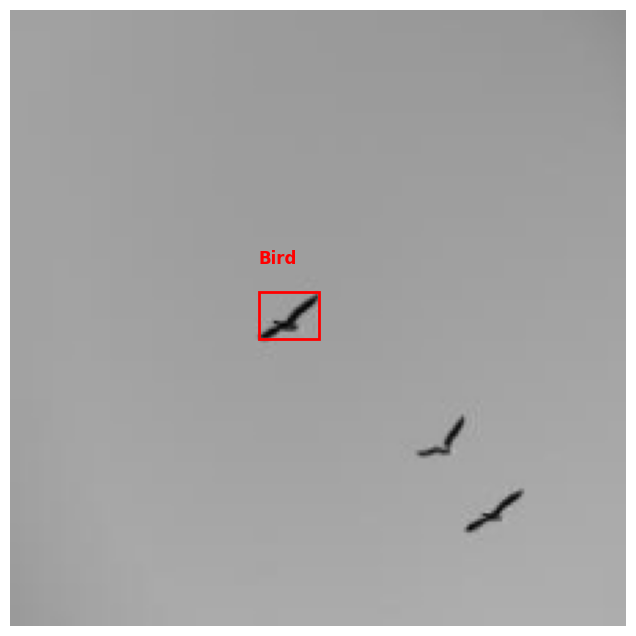

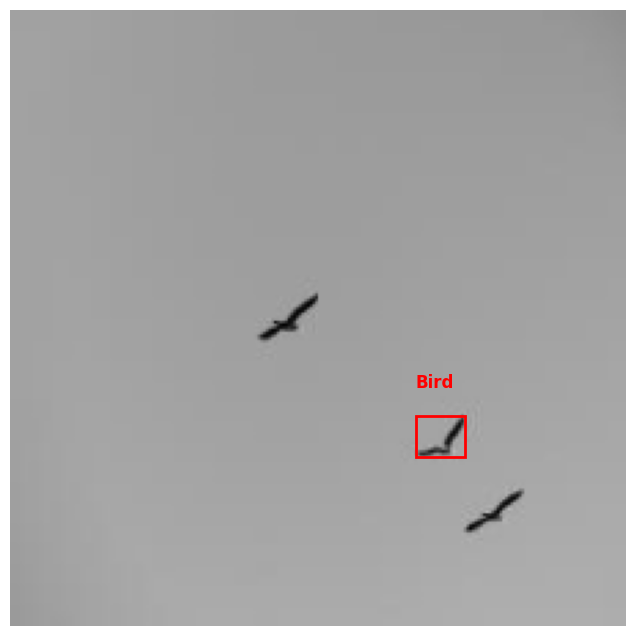

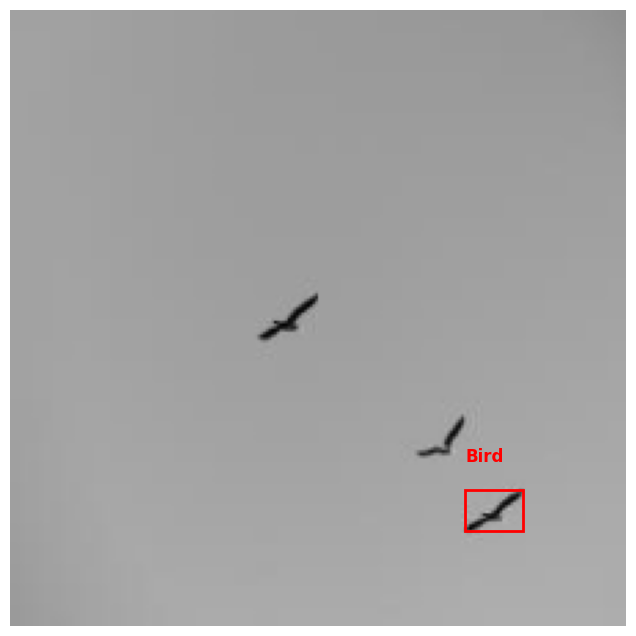

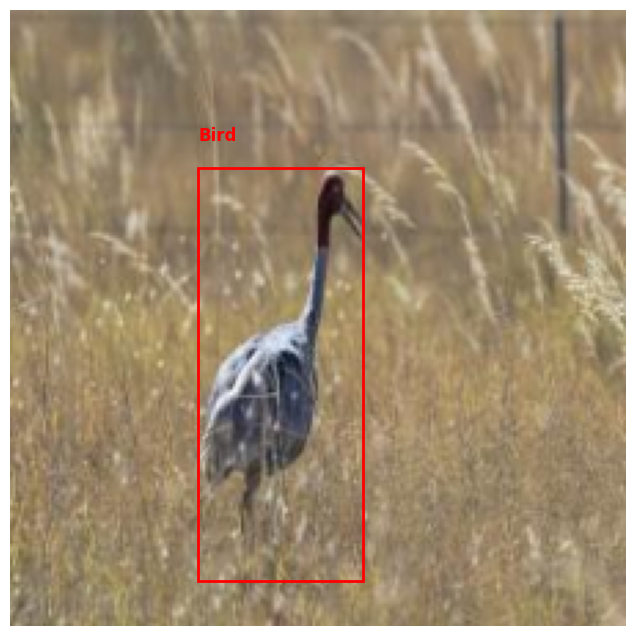

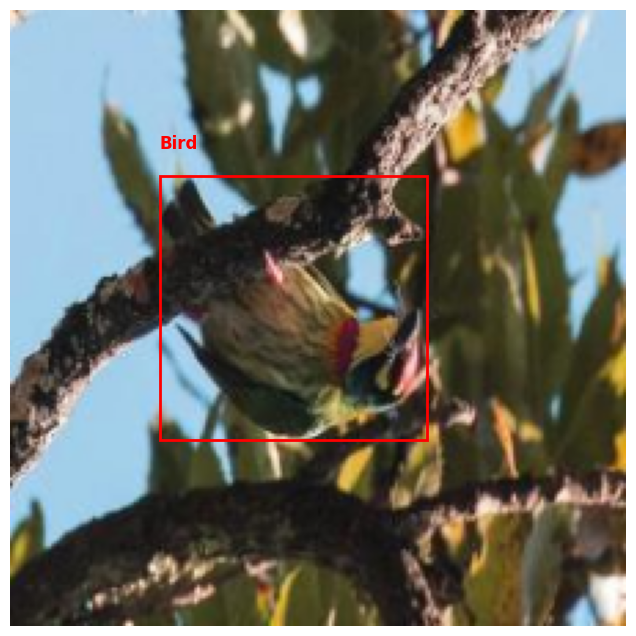

In [7]:
import matplotlib.pyplot as plt

# Class names (replace these with your actual class names)
class_names = {0: 'SuperBird', 1: 'Bird', 2: 'Background'}

def visualize_dataset(images, bboxes, labels, num_images=5):
    for i in range(num_images):
        image = images[i]
        bbox = bboxes[i]
        label = labels[i]

        # Denormalize bounding box
        h, w, _ = image.shape
        x_min, y_min, x_max, y_max = bbox
        x_min = int(x_min * w)
        y_min = int(y_min * h)
        x_max = int(x_max * w)
        y_max = int(y_max * h)

        # Plot the image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Plot the bounding box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='red', facecolor='none', linewidth=2))

        # Plot the label
        label_idx = np.argmax(label)  # Get the index of the class
        class_name = class_names[label_idx]
        plt.text(x_min, y_min - 10, class_name, color='red', fontsize=12, weight='bold')

        plt.axis('off')
        plt.show()

# Visualize 5 images
visualize_dataset(X, y_bboxes, y_labels, num_images=5)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [9]:
def create_model(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)

    # Output layers
    bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)
    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)

    # Model
    model = models.Model(inputs=inputs, outputs=[bbox_output, class_output])

    return model


In [ ]:
from tensorflow.keras.callbacks import TensorBoard

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)


In [10]:
model = create_model(input_shape=(224, 224, 3), num_classes=3)

model.compile(optimizer='adam',
              loss={'bbox_output': 'mean_squared_error', 'class_output': 'categorical_crossentropy'},
              metrics={'bbox_output': 'mse', 'class_output': 'accuracy'})


In [12]:
# Assuming X_train is your input images, y_bbox_train is the bounding box labels, and y_class_train is the class labels
history = model.fit(X_train, 
                    {'bbox_output': y_bboxes_train, 'class_output': y_labels_train},
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, {'bbox_output': y_bboxes_val, 'class_output': y_labels_val})
                    callbacks=[tensorboard_callback])


Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - bbox_output_loss: 0.2737 - bbox_output_mse: 0.2737 - class_output_accuracy: 0.9161 - class_output_loss: 19.7501 - loss: 20.0239 - val_bbox_output_loss: 0.0737 - val_bbox_output_mse: 0.0738 - val_class_output_accuracy: 0.9965 - val_class_output_loss: 0.0083 - val_loss: 0.0821
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 132s 733ms/step - bbox_output_loss: 0.0693 - bbox_output_mse: 0.0693 - class_output_accuracy: 0.9978 - class_output_loss: 0.0068 - loss: 0.0760 - val_bbox_output_loss: 0.0654 - val_bbox_output_mse: 0.0654 - val_class_output_accuracy: 0.9993 - val_class_output_loss: 0.0012 - val_loss: 0.0666
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 110s 613ms/step - bbox_output_loss: 0.0627 - bbox_output_mse: 0.0627 - class_output_accuracy: 0.9987 - class_output_loss: 0.0076 - loss: 0.0703 - val_bbox_output_loss: 0.0628 - val_bbox_output_mse: 0.0628 - val_class_output_accuracy: 0.9993 - val_class_output_loss: 0.0030 - val_loss: 0.0658
Epoch

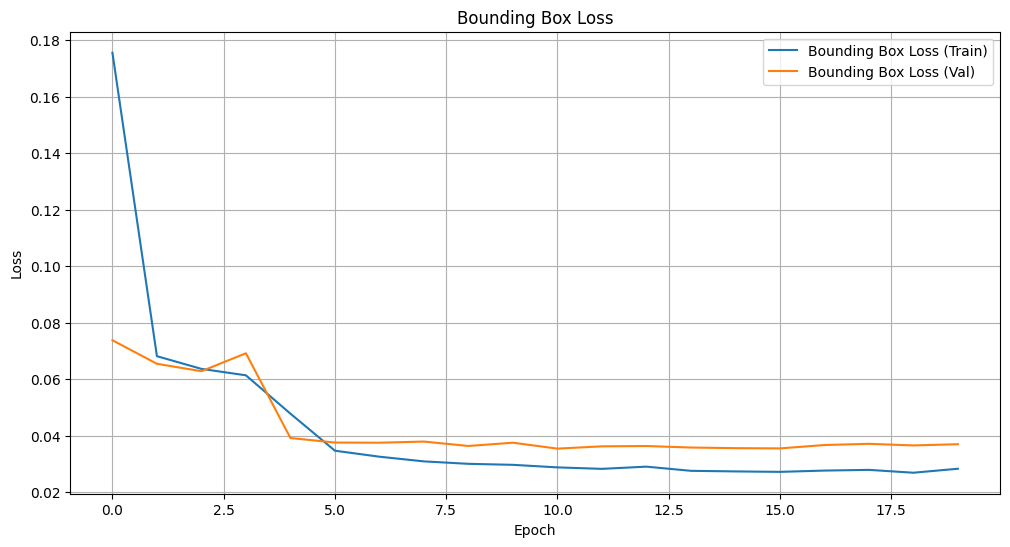

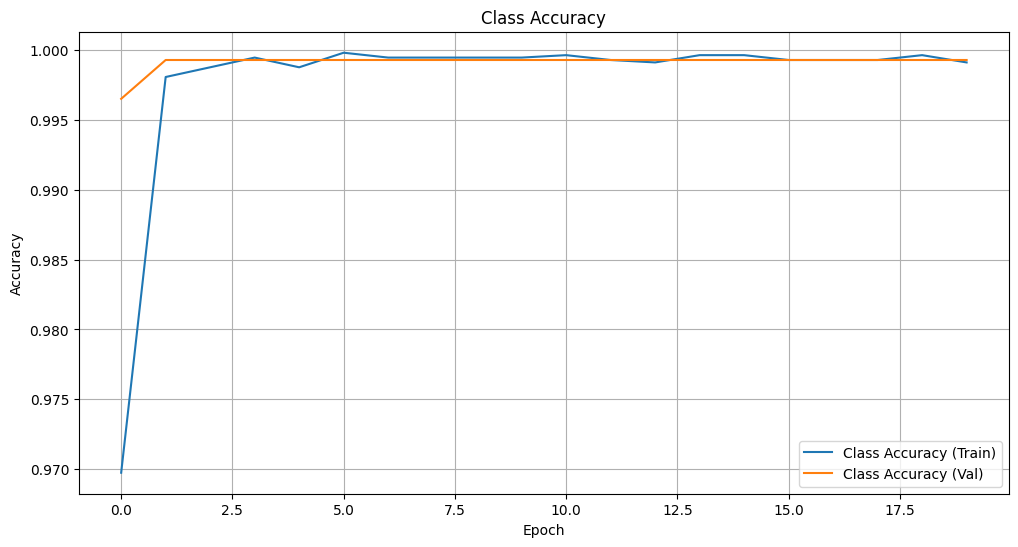

In [13]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot bounding box loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['bbox_output_loss'], label='Bounding Box Loss (Train)')
    plt.plot(history.history['val_bbox_output_loss'], label='Bounding Box Loss (Val)')
    plt.title('Bounding Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot class accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['class_output_accuracy'], label='Class Accuracy (Train)')
    plt.plot(history.history['val_class_output_accuracy'], label='Class Accuracy (Val)')
    plt.title('Class Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the metrics
plot_metrics(history)


In [16]:
import json
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load the JSON file
with open('Bird/annotations/test_annotations.json', 'r') as f:
    annotations_test = json.load(f)

In [18]:

# Specify the directory where images are stored
image_dir = r'Bird/images/test'

# Load the dataset
X_test, y_bboxes_test, y_labels_test = load_dataset(annotations_test, image_dir, input_shape=(224, 224), num_classes=3)

In [20]:
# Assuming X_test is your test images
bbox_pred, class_pred = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


TypeError: cannot unpack non-iterable numpy.float64 object

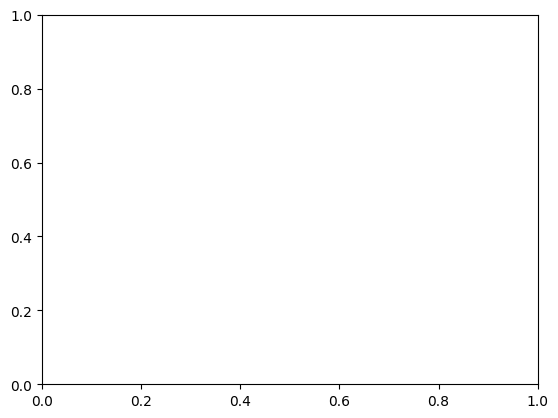

In [21]:
import matplotlib.pyplot as plt
import cv2

def visualize_predictions_vs_ground_truth(image, bbox_pred, bbox_test, class_pred, class_names):
    # Denormalize the bounding boxes
    h, w, _ = image.shape
    
    # Predicted bounding boxes
    for bbox in bbox_pred:
        x_min, y_min, x_max, y_max = bbox
        x_min = int(x_min * w)
        y_min = int(y_min * h)
        x_max = int(x_max * w)
        y_max = int(y_max * h)
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='red', facecolor='none', linewidth=2))
    
    # Ground truth bounding boxes
    for bbox in bbox_test:
        x_min, y_min, x_max, y_max = bbox
        x_min = int(x_min * w)
        y_min = int(y_min * h)
        x_max = int(x_max * w)
        y_max = int(y_max * h)
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='green', facecolor='none', linewidth=2, linestyle='--'))

    # Plot class labels
    label_idx = np.argmax(class_pred)  # Get the index of the class
    class_name = class_names[label_idx]
    plt.text(10, 10, class_name, color='blue', fontsize=12, weight='bold')

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example: Visualizing the predictions vs. ground truth
visualize_predictions_vs_ground_truth(X_test[0], bbox_pred, y_bboxes_test[0], class_pred, class_names={0: 'Class 1', 1: 'Class 2', 2: 'Class 3'})


In [22]:
def calculate_iou(bbox_pred, bbox_true):
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = bbox_pred
    x_min_true, y_min_true, x_max_true, y_max_true = bbox_true
    
    # Compute intersection
    x_min_inter = max(x_min_pred, x_min_true)
    y_min_inter = max(y_min_pred, y_min_true)
    x_max_inter = min(x_max_pred, x_max_true)
    y_max_inter = min(y_max_pred, y_max_true)
    
    # Compute intersection area
    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)
    
    # Compute areas
    bbox_pred_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
    bbox_true_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
    
    # Compute union area
    union_area = bbox_pred_area + bbox_true_area - inter_area
    
    # Compute IoU
    iou = inter_area / union_area
    return iou

# Example: Calculate IoU for the first prediction and ground truth
iou = calculate_iou(bbox_pred[0], y_bboxes_test[0][0])
print(f"IoU: {iou:.2f}")


TypeError: cannot unpack non-iterable numpy.float64 object

In [23]:
model.evaluate(X_test, 
               {'bbox_output': y_bboxes_test, 'class_output': y_labels_test})

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - bbox_output_loss: 0.0424 - bbox_output_mse: 0.0424 - class_output_accuracy: 0.9898 - class_output_loss: 0.0802 - loss: 0.1228


[0.10866915434598923,
 0.040931664407253265,
 0.06627272814512253,
 0.04108206182718277,
 0.9914893507957458]

In [ ]:
def evaluate_model_performance(bbox_preds, bbox_tests, iou_threshold=0.5):
    ious = []
    for bbox_pred, bbox_test in zip(bbox_preds, bbox_tests):
        iou = calculate_iou(bbox_pred, bbox_test)
        ious.append(iou)
    
    # Compute performance metrics
    true_positives = sum(iou > iou_threshold for iou in ious)
    false_positives = len(bbox_preds) - true_positives
    false_negatives = len(bbox_tests) - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score

# Example: Evaluate performance on the entire dataset
precision, recall, f1_score = evaluate_model_performance(bbox_pred, y_bboxes_test)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


In [24]:
# Save the entire model to a file
model.save('Bird/trained_models/newModel/my_model.h5')

In [25]:
from tensorflow.keras.models import load_model

# Load the model from the file
loaded_model = load_model('Bird/trained_models/newModel/my_model.h5')

# Now you can use the model for prediction or further training
bbox_pred, class_pred = loaded_model.predict(X_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


In [26]:
from tensorflow.keras.models import load_model

# Load the previously saved model
loaded_model = load_model('Bird/trained_models/newModel/my_model.h5')

In [27]:
import tensorflow as tf

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('Bird/trained_models/newModel/my_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\omini\AppData\Local\Temp\tmp_ovfxyzf\assets


INFO:tensorflow:Assets written to: C:\Users\omini\AppData\Local\Temp\tmp_ovfxyzf\assets


Saved artifact at 'C:\Users\omini\AppData\Local\Temp\tmp_ovfxyzf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  1364520839184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364693138896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364693134096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364519715856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364519715664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364519716624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364519716816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364519717392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364519717584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1364519718

In [28]:
import numpy as np
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='Bird/trained_models/newModel/my_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare your input data (must be the same shape as the model input)
input_data = np.expand_dims(X_test[0], axis=0).astype(np.float32)

# Set the tensor to point to the input data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the interpreter
interpreter.invoke()

# Get the results
bbox_pred = interpreter.get_tensor(output_details[0]['index'])
class_pred = interpreter.get_tensor(output_details[1]['index'])

print(f"Bounding Box Prediction: {bbox_pred}")
print(f"Class Prediction: {class_pred}")

Bounding Box Prediction: [[4.5594911e-07 9.9828941e-01 1.7101134e-03]]
Class Prediction: [[0.3143735  0.2665845  0.6928903  0.74439037]]


In [35]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='Bird/trained_models/newModel/my_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [36]:
def run_inference_tflite(interpreter, image):
    # Preprocess the input image
    input_data = np.expand_dims(image, axis=0).astype(np.float32)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the results
    bbox_pred = interpreter.get_tensor(output_details[1]['index'])
    class_pred = interpreter.get_tensor(output_details[0]['index'])

    return bbox_pred[0], class_pred[0]

# Example: Running inference on the first test image
bbox_pred, class_pred = run_inference_tflite(interpreter, X_test[0])


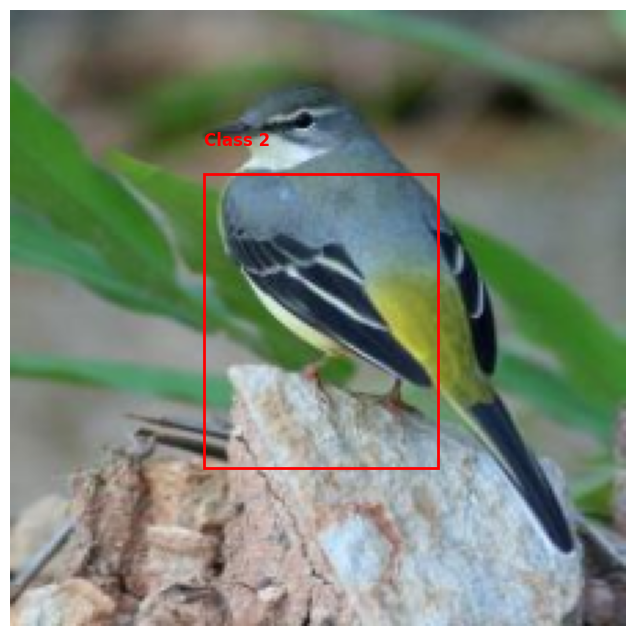

In [38]:
def visualize_tflite_output(image, bbox, class_pred, class_names):
    # Denormalize the bounding box
    h, w, _ = image.shape
    x_min, y_min, x_max, y_max = bbox
    x_min = int(x_min * w)
    y_min = int(y_min * h)
    x_max = int(x_max * w)
    y_max = int(y_max * h)

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Plot the bounding box
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                      edgecolor='red', facecolor='none', linewidth=2))

    # Plot the label
    label_idx = np.argmax(class_pred)  # Get the index of the class
    class_name = class_names[label_idx]
    plt.text(x_min, y_min - 10, class_name, color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Visualize the result
visualize_tflite_output(X_test[55], bbox_pred, class_pred, class_names={0: 'Class 1', 1: 'Class 2', 2: 'Class 3'})
